### Analysis 4: Are there any correlations between crime and availability of programs in certain districts?
*By Pedro*

To examine the impact of crime on the Chicago Communities, our initial first step was to exploratorily visualize the number of programs in each of the chicago communities, and compare to the number of crime incidents for the year 2022. By using geopandas to impute the locations of the programs within the Chicago communities, we created the following visualizations that shows this data side by side.

/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72065/2721835075.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime['Date'] = pd.to_datetime(crime['Date'])
/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72065/2721835075.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime['updated_on'] = pd.to_datetime(crime['Updated On'])
/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72065/2721835075.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid


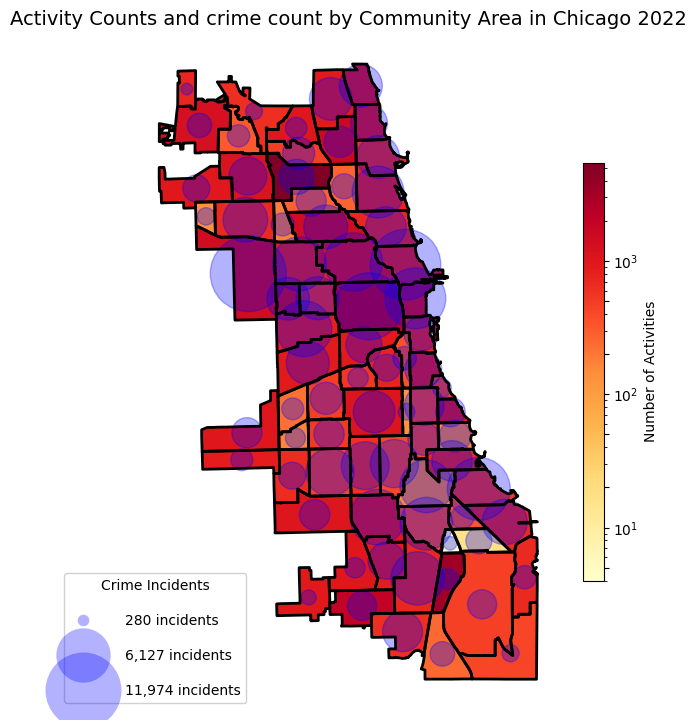

In [ ]:
# !echo false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
# read the shape file, read all the datasets
shp_file = gpd.read_file('datasets/geo_export_26bce2f2-c163-42a9-9329-9ca6e082c5e9.shp')
shp_file.set_crs(epsg=4326, inplace=True)
shp_file['geometry_polygon'] = shp_file['geometry']
# exclude O'hare 
shp_file = shp_file.loc[~(shp_file['community']== "OHARE")]
crime = pd.read_csv("datasets/Crimes_-_2022.csv")
data = pd.read_csv("datasets/My_CHI._My_Future._Programs.csv")
crime['Date'] = pd.to_datetime(crime['Date'])
crime['updated_on'] = pd.to_datetime(crime['Updated On'])
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['End Date'] = pd.to_datetime(data['End Date'])
# select observations where latitude and longitude or Location are not missing
has_latlong = ~data[['Latitude', 'Longitude']].isna().all(axis=1)
has_location = ~data['Location'].isna()
location_data = data[has_latlong  | has_location]
# remove the kansas observation
location_data = location_data[location_data['State'] != 'KS']
# drop the crime missing values as rows
crime.dropna(axis='rows',how='any', inplace=True) 
location_data = location_data.copy()
location_data.drop(['Image', 'Program URL', 'Registration URL', 'Registration Open', 
                   'Contact Phone', 'Contact Email', 'Hidden Programs', 'Featured', 
                   'Meeting Type', 'Has Free Food', 'Transport Provided', 'Participants Paid', 'Contact Name', 'Program ID', 
                   'Online Address', 'State', 'Registration Deadline', 'Scholarship Available'], 
                   axis='columns', inplace=True)
# convert the latitude and longitude into geopandas point objects
geometry = [Point(xy) for xy in zip(location_data['Longitude'], location_data['Latitude'])]
gdf_points = gpd.GeoDataFrame(location_data, geometry=geometry)
# set coordinate reference system
gdf_points.set_crs(epsg=4326, inplace=True)
# do a spacial join to find the communities for each of the points
points_with_labels = gpd.sjoin(gdf_points, shp_file, how='left', predicate='within')
points_with_labels = points_with_labels.dropna(subset=['community'])
points_with_labels = points_with_labels.loc[~(points_with_labels['community'] == 'OHARE')]
# select the programs from 2022, as the crime data only goes back to 2022
grouped_sizes = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].groupby('community').size()
grouped_sizes_sorted = grouped_sizes.sort_values(ascending=False)
community_counts = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].groupby('community').size().reset_index(name='count')
    
# do another spacial join of the grouped communities so for each unique community
community_gdf = community_counts.merge(points_with_labels, how='left', on='community').drop_duplicates(subset='community')[['community', 'count', 'geometry_polygon']]
community_gdf = gpd.GeoDataFrame(community_gdf, geometry='geometry_polygon')

# define plot size
fig, ax = plt.subplots(figsize=(6, 7.5))

community_gdf.plot(
    column='count',
    ax=ax,
    legend=True,
    legend_kwds={
        'label': 'Number of Activities',
        'orientation': 'vertical',
        # create ticks in order to view orders of magnitude
        'ticks': [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000], 
        # make the bar a little smaller
        'shrink': 0.6
    },
    missing_kwds={'color': 'lightgrey'},
    cmap='YlOrRd',
    # add the logarithmic scale so that orders of magnitude can be appreciated.
    norm=LogNorm()
)

# do the same for the crime lat and long
geometry = [Point(xy) for xy in zip(crime['Longitude'], crime['Latitude'])]
crime_gdf_points = gpd.GeoDataFrame(crime, geometry=geometry)
# set coordinate reference system again.
crime_gdf_points.set_crs(epsg=4326, inplace=True)
crime_points_with_labels = gpd.sjoin(crime_gdf_points, shp_file, how='left', predicate='within')
crime_sum = crime_points_with_labels.groupby('community').size().reset_index(name='count')
crime_sum = crime_sum.merge(crime_points_with_labels, how='left', on='community').drop_duplicates(subset='community')[['community', 'count', 'geometry_polygon']]
# get geotaframe and find center of mass, center of object to place the density circle on the map
crime_sum = gpd.GeoDataFrame(crime_sum, geometry='geometry_polygon', crs="EPSG:4326")
crime_sum['centroid'] = crime_sum['geometry_polygon'].centroid
crime_sum.set_geometry('centroid',inplace=True)
min_count = crime_sum['count'].min()
max_count = crime_sum['count'].max()
# make the circle size dependent on the frequency of crime in the community
crime_sum.plot(
    ax=ax,
    color='blue',  
    alpha=0.3,     
    marker='.',   
    markersize=crime_sum['count'],   
)
shp_file.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2)

legend_elements = [Line2D([0], [0], marker='.', color='w', 
                         markerfacecolor='blue', markersize=1, alpha=0.3,
                         label='Crime Incidents (Larger is worse)')]
ax.legend(handles=legend_elements, loc='upper left')
legend_sizes = [
    min_count,
    (min_count + max_count) / 2, 
    max_count
]
legend_elements = []
# add sizes for each relevant min max and middle of range
for size in legend_sizes:
  legend_elements.append(
      Line2D([0], [0],
              marker='o',
              color='none',
              markerfacecolor='blue',
              markeredgecolor='none',
              markersize=np.sqrt(size)*0.5,  
              alpha=0.3,
              label=f'{int(size):,} incidents')
  )



plt.legend(handles=legend_elements,
          title='Crime Incidents',
          loc='lower left',
          frameon=True,
          framealpha=0.9,
          labelspacing=1.5,
          handletextpad=2,
          bbox_to_anchor=(-0.2, 0.00))  
plt.title('Activity Counts and crime count by Community Area in Chicago 2022', fontsize=14)
ax.set_axis_off()
plt.tight_layout()

In the visualization we can see that there seems to be no apparent correlation between the number of activities and crime incidents in 2022, but we can see that the higher magnitudes of crime are mostly in the southern and northwest communities. What did catch our eye was that for both the number of crime incidents and the number of activities there is a difference of about two magnitude between some of the most violent and most prosperous communities, and for the communities with the highest number of activities. 

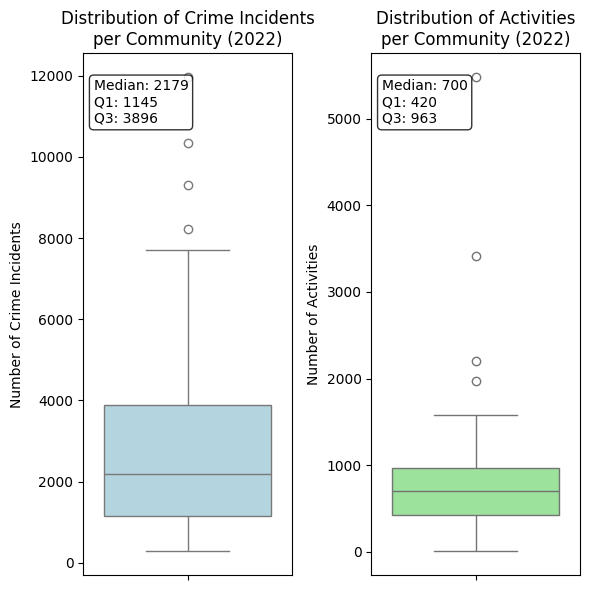

In [ ]:
# !echo false
import matplotlib.pyplot as plt
import seaborn as sns
# repeat steps for crime geodataframe.

geometry = [Point(xy) for xy in zip(crime['Longitude'], crime['Latitude'])]
crime_gdf_points = gpd.GeoDataFrame(crime, geometry=geometry)
crime_gdf_points.set_crs(epsg=4326, inplace=True)
crime_points_with_labels = gpd.sjoin(crime_gdf_points, shp_file, how='left', predicate='within')
crime_per_community = crime_points_with_labels.groupby('community').size().reset_index(name='crime_count')

# get activities for 2022
activities_2022 = points_with_labels[points_with_labels['Start Date'].dt.year == 2022]
activities_per_community = activities_2022.groupby('community').size().reset_index(name='activity_count')

# define two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))

sns.boxplot(y='crime_count', data=crime_per_community, ax=ax1, color='lightblue')
ax1.set_title('Distribution of Crime Incidents\nper Community (2022)')
ax1.set_ylabel('Number of Crime Incidents')

sns.boxplot(y='activity_count', data=activities_per_community, ax=ax2, color='lightgreen')
ax2.set_title('Distribution of Activities\nper Community (2022)')
ax2.set_ylabel('Number of Activities')
# add information on the quantiles 
for ax, data, column in [(ax1, crime_per_community, 'crime_count'), 
                        (ax2, activities_per_community, 'activity_count')]:
    median = data[column].median()
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    
    stats_text = f'Median: {median:.0f}\nQ1: {q1:.0f}\nQ3: {q3:.0f}'
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

In [ ]:
# !echo false
# define function for IQR outliers.
def get_outliers(df, value_column, name_column):
    Q1 = df[value_column].quantile(0.25)
    Q3 = df[value_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[
        (df[value_column] < lower_bound) |
        (df[value_column] > upper_bound)
    ].sort_values(by=value_column, ascending=False)
    
    return outliers[[name_column, value_column]]
# get ouliers from crime
print("Crime Outliers (Communities with unusually high or low crime counts):")
crime_outliers = get_outliers(crime_per_community, 'crime_count', 'community')
display(crime_outliers)

# get outliers for activities
print("\nActivity Outliers (Communities with unusually high or low activity counts):")
activity_outliers = get_outliers(activities_per_community, 'activity_count', 'community')
display(activity_outliers)

# create a small dataframe with summary statistics in a nice format.
summary_stats = pd.DataFrame({
    'Metric': [
        'Total communities with outlier crime counts',
        'Average crime count across all communities',
        'Median crime count across all communities',
        'Total communities with outlier activity counts',
        'Average activity count across all communities',
        'Median activity count across all communities'
    ],
    'Value': [
        len(crime_outliers),
        f"{crime_per_community['crime_count'].mean():.1f}",
        f"{crime_per_community['crime_count'].median():.1f}",
        len(activity_outliers),
        f"{activities_per_community['activity_count'].mean():.1f}",
        f"{activities_per_community['activity_count'].median():.1f}"
    ]
})

print("\nSummary Statistics:")
display(summary_stats)

Crime Outliers (Communities with unusually high or low crime counts):


,community,crime_count
5,AUSTIN,11974
47,NEAR NORTH SIDE,10335
49,NEAR WEST SIDE,9304
64,SOUTH SHORE,8213



Activity Outliers (Communities with unusually high or low activity counts):


,community,activity_count
34,IRVING PARK,5482
57,PULLMAN,3417
49,NEAR WEST SIDE,2206
45,MORGAN PARK,1974



Summary Statistics:


,Metric,Value
0,Total communities with outlier crime counts,4
1,Average crime count across all communities,3051.4
2,Median crime count across all communities,2179.0
3,Total communities with outlier activity counts,4
4,Average activity count across all communities,812.5
5,Median activity count across all communities,700.0


To further visualize the disparity in safety and program access, this boxplot helps to see just how many orders of magnitude the outliers are in terms of crime and number of activities. Among the outliers for crime (with respective crime count), communities such as Austin (11974), Near North Side (10335), Near West Side (9304) and South Shore (8213) are about two to three times more violent than the average of crime in communities (3051 incidents, and median 2179). With respect to the activity data, places such as Irving Park (5482), Pullman (3417), Near West Side (2206) and Morgan Park (1974) are up to 6 times the mean activity count (812.5 activities and median 700). 

In an effort to further investigate the relationship between crime and the number of activities, we grouped the number of incidents per month in 2022, as well as the number of activities per month and computed a total correlation coefficient, which turned out to be -0.088, but upon drilling down on the correlations between crime and number of activities per district we discovered that in some communities crime and programs do have a meaningful relationship.

/var/folders/52/y8mfvm1n6vj12ntkl_p9hqw80000gn/T/ipykernel_72065/3810813111.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  community_correlations = merged_df_filtered.groupby('community').apply(


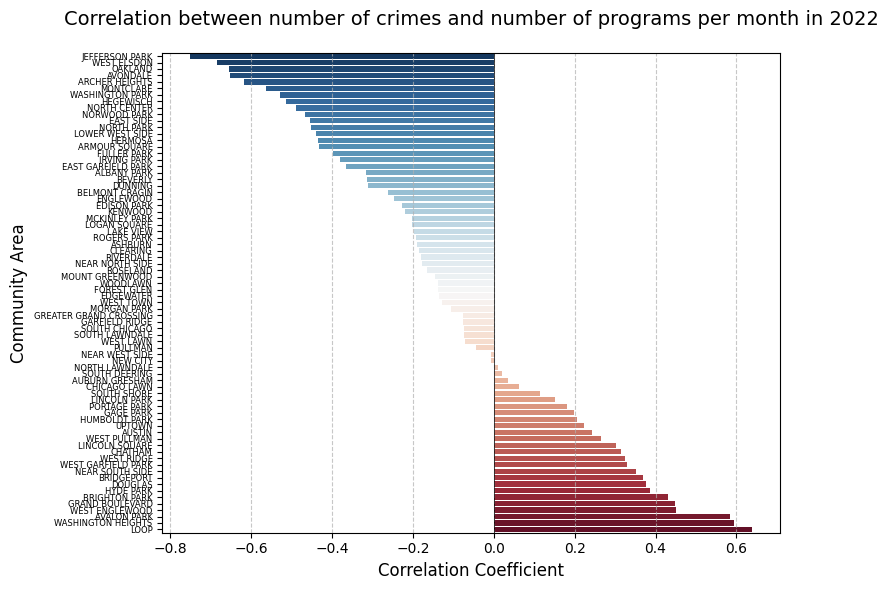

In [ ]:
# !echo false
# repeat old steps, groupby month
points_with_labels_2022 = points_with_labels[points_with_labels['Start Date'].dt.year == 2022].copy()
points_with_labels_2022['month'] = points_with_labels_2022['Start Date'].dt.month
programs_by_month = points_with_labels_2022.groupby(['community', 'month']).size()
programs_by_month = programs_by_month.reset_index(name='program_count')

crime_points_with_labels['month'] = crime_points_with_labels.Date.dt.month
crimes_by_month = crime_points_with_labels.groupby(['community','month']).size()
crimes_by_month = crimes_by_month.reset_index(name='crime_count')

# merged the grouped activity and community by month
merged_df = programs_by_month.merge(crimes_by_month, on=['community', 'month'])

# remove calumet heights as this only has information about two months
merged_df_filtered = merged_df[merged_df['community'] != 'CALUMET HEIGHTS']

# if the group has more than one observations, calculate correlation
def calculate_correlation(group):
    if len(group) > 1:
        return group['program_count'].corr(group['crime_count'])
    return np.nan

community_correlations = merged_df_filtered.groupby('community').apply(
    calculate_correlation
).dropna()
# sort the correlatation in preparation for plotting.
sorted_corr = community_correlations.sort_values()

plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=pd.DataFrame({
        'correlation': sorted_corr.values,
        'community': sorted_corr.index
    }),
    x='correlation',
    y='community',
    hue='community',
    palette="RdBu_r",
    legend=False
)

ax.tick_params(axis='y', labelsize=6)
plt.title("Correlation between number of crimes and number of programs per month in 2022",
          pad=20,
          size=14)
plt.xlabel("Correlation Coefficient", size=12)
plt.ylabel("Community Area", size=12)
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

In this plot, we can see that broken down into monthly frequency, there are many strong negative correlations between crime and number of activities as well as some moderately positive and negative correlations. By dropping calumet heights which had a misleading negative correlation of -1 due to missing data points on most of the year, we view quite a compelling picture for some crime ridden communities in terms of lack of access to programs.

To further analyze the relationship between crime and number of programs, we can drill down into the individual plots that peer into the possible seasonality and relationship of crime per month for the top 3 strongest positive and negative correlations.

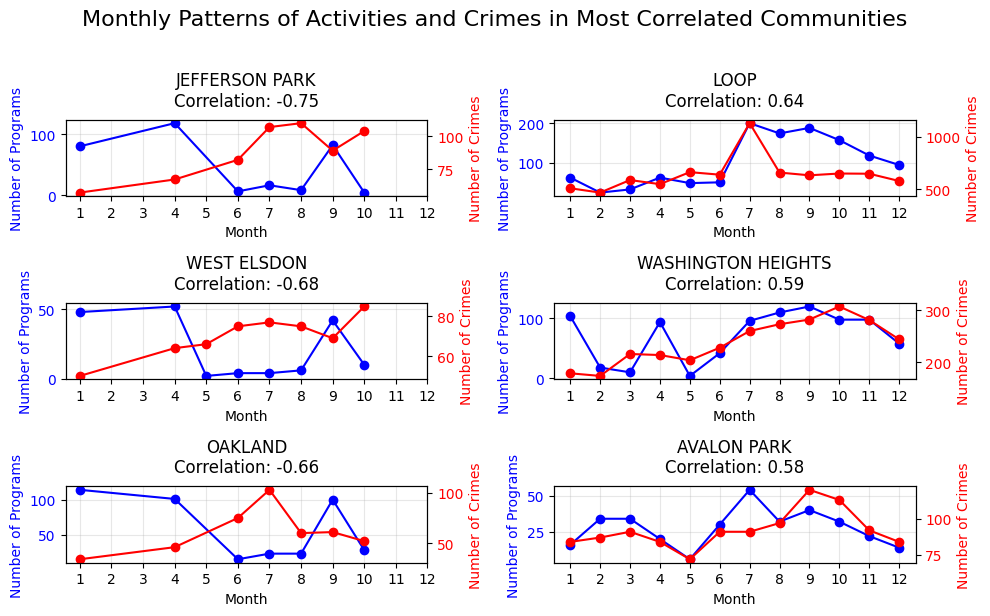

In [ ]:
# !echo false
# grab the top 3 for positive and negative correlation, which are under investigation
top_pos = sorted_corr.nlargest(3)
top_neg = sorted_corr.nsmallest(3)
communities_to_plot = pd.concat([top_neg, top_pos])

fig, axes = plt.subplots(3, 2, figsize=(10, 6))
fig.suptitle('Monthly Patterns of Activities and Crimes in Most Correlated Communities', size=16, y=1.02)

# for all of these, create lineplots of the data and display their correlations
for idx, (community, correlation) in enumerate(communities_to_plot.items()):
  community_data = merged_df[merged_df['community'] == community]
  row = idx % 3
  col = 0 if idx < 3 else 1
  
  ax1 = axes[row, col]
  ax2 = ax1.twinx()
  
  line1 = ax1.plot(community_data['month'], community_data['program_count'], 
                    color='blue', label='Programs', marker='o')
  line2 = ax2.plot(community_data['month'], community_data['crime_count'], 
                    color='red', label='Crimes', marker='o')
  
  ax1.set_title(f'{community}\nCorrelation: {correlation:.2f}', pad=10)
  
  ax1.set_xticks(range(1, 13))
  ax1.set_xlabel('Month')
  
  ax1.set_ylabel('Number of Programs', color='blue')
  ax2.set_ylabel('Number of Crimes', color='red')
  
  ax1.tick_params(axis='y', labelcolor='blue')
  ax2.tick_params(axis='y', labelcolor='red')
  
  ax1.grid(True, alpha=0.3)
  
  lines = line1 + line2
  labels = [l.get_label() for l in lines]

plt.tight_layout()

As we can see, there are clear trends in the seasonality of crime in relation to the number of programs available. The most negatively correlated communities (Jefferson Park, West Elsdon, and Oakland) show an inverse relationship where program activity tends to decrease as crime increases, with programs typically peaking in spring months while crime rises during summer and fall. This pattern is particularly pronounced in Jefferson Park, where program activity drops sharply as crime rates climb. In contrast, positively correlated communities like the Loop, Washington Heights, and Avalon Park demonstrate synchronized movements between programs and crime rates, with both metrics often peaking during later months and showing similar seasonal patterns. The Loop, notably, has the highest overall numbers of both programs and crimes, with concurrent peaks around August. While these correlations are clear, they don't necessarily indicate causation; the relationships could be influenced by various factors such as weather patterns or population density. 

For the previous reasons, it is productive to conduct statistical hypothesis testing to determine which of the outliers are sufficiently correlated to determine that it might be more reasonable to suspect causation. That is, of statistical significance $\alpha=0.05$



For testing the relationship between crime and program availability:

$$H_0: \rho = \mu$$
$$H_1: \rho \neq \mu$$

Where:
- $\rho$ represents the correlation coefficient for an individual community
- $\mu$ represents the global mean correlation (-0.088)

The statistical analysis examines whether the observed correlations in selected Chicago communities significantly differ from the global mean correlation across all communities. For areas showing negative correlations (Jefferson Park, West Elsdon, and Oakland), we tested if their strong inverse relationships between programs and crime were statistically significant, while for positively correlated communities , we evaluated whether their positive associations genuinely differed from the city-wide average. In both cases, the p-value indicates the probability of observing correlations of such magnitude if the true correlation were actually equal to the global mean. When the p-value falls below 0.05, we can reject the null hypothesis, suggesting that these communities exhibit genuinely distinct relationships between programs and crime rates rather than variations that could have occurred by chance within Chicago's overall pattern.

In [ ]:
# !echo false
import scipy
import pandas as pd
import numpy as np

# get the global mean
global_mean_corr = community_correlations.mean()

def fisher_z(r):
  return 0.5 * np.log((1 + r) / (1 - r))

def fisher_z_test(r1, r2, n1, n2):
  z1 = fisher_z(r1)
  z2 = fisher_z(r2)
  se = np.sqrt(1/(n1-3) + 1/(n2-3))
  z_stat = (z1 - z2) / se
  # calculate two-tailed p-value using normal distribution
  p_value = 2 * (1 - scipy.stats.norm.cdf(abs(z_stat)))
  return p_value

# select specific districts for analysis
districts_to_test = [
    'JEFFERSON PARK', 'WEST ELSDON', 'OAKLAND',
    'LOOP', 'WASHINGTON HEIGHTS', 'AVALON PARK'
]

print(f"Global Mean Correlation: {global_mean_corr:.3f}\n")

results = []
for district in districts_to_test:
  district_data = merged_df[merged_df['community'] == district]
  district_corr = district_data['program_count'].corr(district_data['crime_count'])
  n_district = len(district_data)
  n_global = len(merged_df)
  # perform statistical test comparing district to global
  p_value = fisher_z_test(district_corr, global_mean_corr, n_district, n_global)
  significant = 1 if p_value < 0.05 else 0
  
  results.append({
      'District': district,
      'Correlation': f"{district_corr:.3f}",
      'p-value': f"{p_value:.3f}",
      'Significant?': significant
  })

# convert results to DataFrame
results_df = pd.DataFrame(results)
print("Hypothesis Test Results:")
display(results_df)



Global Mean Correlation: -0.088

Hypothesis Test Results:


,District,Correlation,p-value,Significant?
0,JEFFERSON PARK,-0.751,0.077,0
1,WEST ELSDON,-0.684,0.095,0
2,OAKLAND,-0.656,0.164,0
3,LOOP,0.638,0.012,1
4,WASHINGTON HEIGHTS,0.594,0.021,1
5,AVALON PARK,0.585,0.024,1


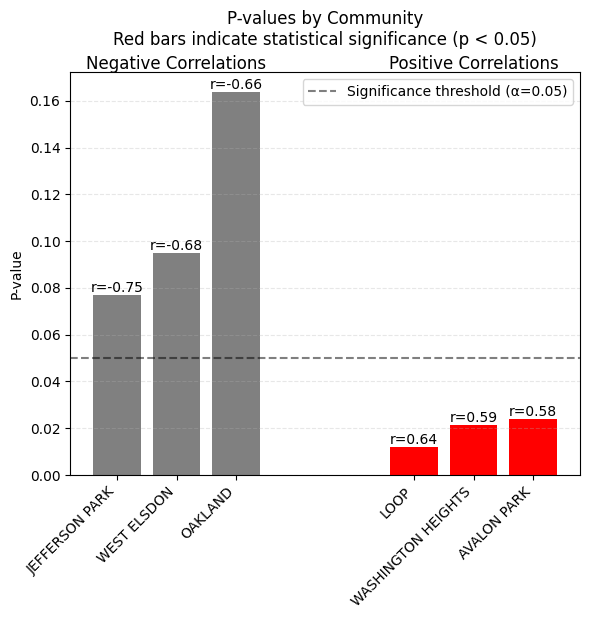

In [ ]:
# !echo false
import matplotlib.pyplot as plt
import numpy as np

districts = {
  'Negative': ['JEFFERSON PARK', 'WEST ELSDON', 'OAKLAND'],
  'Positive': ['LOOP', 'WASHINGTON HEIGHTS', 'AVALON PARK']
}

# define plot size
plt.figure(figsize=(6, 6))

results = {'Negative': [], 'Positive': []}
for correlation_type, district_list in districts.items():
  for district in district_list:
    district_data = merged_df[merged_df['community'] == district]
    district_corr = district_data['program_count'].corr(district_data['crime_count'])
    n_district = len(district_data)
    n_global = len(merged_df)
    # perform statistical test
    p_value = fisher_z_test(district_corr, global_mean_corr, n_district, n_global)
    results[correlation_type].append({
      'district': district,
      'correlation': district_corr,
      'p_value': p_value
    })

# Calculate positions for both groups at once
bar_width = 0.8
group_spacing = 2  # Space between negative and positive groups
total_bars = len(districts['Negative']) + len(districts['Positive'])
group_positions = []
labels = []
p_values = []
correlations = []
colors = []

current_x = 0
for i, (corr_type, data) in enumerate(results.items()):
  # sort by absolute correlation value
  data = sorted(data, key=lambda x: abs(x['correlation']), reverse=True)
  
  for d in data:
    group_positions.append(current_x)
    labels.append(d['district'])
    p_values.append(d['p_value'])
    correlations.append(d['correlation'])
    colors.append('red' if d['p_value'] < 0.05 else 'gray')
    current_x += 1
  
  if i < len(results) - 1:  # Add spacing after all groups except the last
    current_x += group_spacing

# Create the bars
bars = plt.bar(group_positions, p_values, color=colors, width=bar_width)

# Add correlation values above bars
for i, corr in enumerate(correlations):
  plt.text(group_positions[i], p_values[i], f'r={corr:.2f}',
           ha='center', va='bottom')

# Customize x-axis
plt.xticks(group_positions, labels, rotation=45, ha='right')

# Add other plot elements
plt.axhline(y=0.05, color='black', linestyle='--', alpha=0.5,
          label='Significance threshold (α=0.05)')
plt.title('P-values by Community\nRed bars indicate statistical significance (p < 0.05)', pad=20)
plt.ylabel('P-value')
plt.grid(True, axis='y', linestyle='--', alpha=0.3)
plt.legend()

# Add group labels
mid_negative = np.mean(group_positions[:len(districts['Negative'])])
mid_positive = np.mean(group_positions[-len(districts['Positive']):])

plt.text(mid_negative, plt.ylim()[1], 'Negative Correlations',
       ha='center', va='bottom', fontsize=12)
plt.text(mid_positive, plt.ylim()[1], 'Positive Correlations',
       ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)

## Conclusions

Do the individual analysis connect with each other to answer a bigger question? If yes, explain.

Our key findings are that there seems to be indeed a geniune correlation between crime and availability of programs in some districts which are Loop, Washington Heights, Avalon Park for positive correlation and Jefferson Park, West Elsdon, Oakland for negative correlation. In the case of the positively correlated relationships, the top three communities with the largest correlated all showed statistically significant positive correlations (p < 0.05) between crime and program availability. Among them, the loop has the strongest positive correlation, but we cannot rule out that this could very well just be an effect of population and seasonality of crime and programs as this is a dense urban area, and given the vast amount of resources and infrastructure to maintain programs regardless of crime. In the case of the negative correlations, while these show strong negative correlations and are close to being statistically significant, with our p-value we cannot conclusively say that this pattern isn't due to chance. 

## Recommendations to stakeholder(s)
What are the action items for the stakeholder(s) based on your analysis? Be as precise as possible. The stakeholder(s) are depending on you to come up with practically implementable recommendations, instead of having to think for themselves.

Do the stakeholder(s) need to be aware about some limitations of your analysis? Can your analysis be directly used by the stakeholder(s) to obtain the expected benefit / make decisions, or do they need to do some further analysis based on their own, or do they need to repeat your analysis on a more recent data for the results to be applicable? 

Based on our analysis of crime and program relationships across Chicago communities, we derived some recommendations for stakeholders: 
- For densely populated areas like the Loop, where we see significant positive correlations between crime and programs, we recommend implementing enhanced crime prevention measures and strategically redistributing some programs to neighboring communities, particularly during months with higher crime rates. 
- For residential communities, we suggest developing program sharing networks between neighboring areas, with a focus on increasing availability during periods when nearby high-crime areas experience peaks in criminal activity. This can be supported by creating "safe corridor" initiatives to facilitate program access and implementing mobile programs that can adapt to seasonal needs and crime patterns. Communities like Jefferson Park and West Elsdon, which show negative correlations between programs and crime, should maintain consistent program availability throughout high-crime months while partnering with local law enforcement to ensure safe access. 
- To optimize resources, communities should coordinate program schedules, share staff during different peak periods, and establish inter-community communication networks for sharing information about program success and crime patterns. Additionally, implementing transportation assistance programs and developing joint community initiatives can help bring together residents from multiple areas while ensuring safe and consistent access to programs across Chicago's diverse communities.